In [1]:
!gdown --id 1qjGcB0b8RYLiYA55uG7YLIyrv2oPUFOE

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1qjGcB0b8RYLiYA55uG7YLIyrv2oPUFOE
To: /content/airline-passengers.csv
100% 2.18k/2.18k [00:00<00:00, 552kB/s]


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv('/content/airline-passengers.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
training_set = np.array(df['Passengers'].values)
training_set = np.expand_dims(training_set, axis=1)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

In [5]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length ):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [6]:
num_epochs = 800
learning_rate = 0.01

input_size = 1
hidden_size = 100
num_layers = 1

num_classes = 1
seq_length = 12

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super().__init__()
        self.num_classes = num_classes  # output size
        self.num_layers = num_layers  # number of recurrent layers in the lstm
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2)  # lstm
        self.fc_1 = nn.Linear(hidden_size, 128)  # fully connected
        self.fc_2 = nn.Linear(128, num_classes)  # fully connected last layer
        self.relu = nn.ReLU()

    def forward(self, x):
        # hidden state
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # cell state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))  # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size)  # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out)  # first dense
        out = self.relu(out)  # relu
        out = self.fc_2(out)  # final output
        return out

In [8]:
def train(training_data):
    x, y = sliding_windows(training_data, seq_length)

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    best_valid_loss = 2

    lstm = LSTM(input_size, hidden_size, num_classes, num_layers)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = lstm(dataX)
        optimizer.zero_grad()
        loss = criterion(outputs, dataY)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch ", epoch)
            print("Loss ", loss.item())

            if loss.item() < best_valid_loss:
                best_valid_loss = loss.item()
                print("Weight saves!")
                torch.save(lstm.state_dict(), 'weight.pth')

In [9]:
train(training_data)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch  0
Loss  0.2357199490070343
Weight saves!
Epoch  100
Loss  0.002661620732396841
Weight saves!
Epoch  200
Loss  0.0012055279221385717
Weight saves!
Epoch  300
Loss  0.000518930668476969
Weight saves!
Epoch  400
Loss  0.00022910026018507779
Weight saves!
Epoch  500
Loss  0.0002092062495648861
Weight saves!
Epoch  600
Loss  0.0001745756744639948
Weight saves!
Epoch  700
Loss  0.00015553378034383059
Weight saves!


In [10]:
model = LSTM(input_size, hidden_size, num_classes, num_layers)
model.load_state_dict(torch.load('weight.pth'))
model.eval()

with torch.no_grad():
  n_days = 11
  res = []
  data = training_data.tolist()

  for i in range(1, n_days):
    test = torch.Tensor(np.array(data[-seq_length:]))

    predict = model(test.unsqueeze(0)).data.numpy()
    res.append(predict.item())

    data.append(predict.tolist()[0])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [11]:
result = np.array(res)
final = sc.inverse_transform(np.expand_dims(result, axis=1))
output = np.squeeze(final, axis=1).tolist()

In [12]:
output

[461.584347486496,
 440.5613888502121,
 446.194354057312,
 477.625900387764,
 499.68984746932983,
 576.3824388980865,
 652.7079241275787,
 641.8294157981873,
 550.2224634885788,
 507.38858008384705]

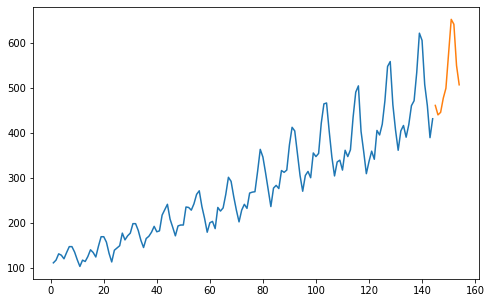

In [13]:
fig = plt.figure(figsize=(8, 5))
value_len = len(training_set)
list1 = [i for i in range(1, value_len + 1)]
list2 = [i for i in range(value_len + 1, value_len + 11)]
plt.plot(list1, training_set)
plt.plot(list2, output)